In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy
import pandas as pd
from pysindy.differentiation import FiniteDifference
import itertools
from sklearn.linear_model import LinearRegression

In [2]:
def linear_damped_SHO(t, x):
    return [-0.1 * x[0] + 2 * x[1], -2 * x[0] - 0.1 * x[1]]

def linear_damped_SHO_temp(x, t):
    return -0.1*x[0]+2*x[1], -2*x[0]-0.1*x[1]

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

def f_lorenz(state, t):
    x, y, z = state  
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

In [3]:
dt = 0.01
t_train = np.arange(0, 25, dt)
t_train_span = (t_train[0], t_train[-1])

x0_train = [2, 0]

X_train_odeint = odeint(linear_damped_SHO_temp, x0_train, t_train)
# X_train_odeint

state0 = [1.0, 1.0, 1.0]
time_steps_lorenz = np.arange(0.0, 40.0, dt)

X_t_lorenz = odeint(f_lorenz, state0, time_steps_lorenz)

In [4]:
fd = FiniteDifference()
X_dot = fd._differentiate(X_train_odeint, t_train)
X_dot_lorenz = fd._differentiate(X_t_lorenz, time_steps_lorenz)
# X_dot

In [5]:
def FiniteDifference_Approximation(XT, timeTr, approxOrder=5,Compute_Boundaries=False, traverse=True):
    # Arguments: Compute_Boundaries and tranverse should not be used by user
    # Use newton forward difference approximation and omits approxOrder # of points form end
    # XT has number of array=len(timeTr) and each array has n instaces where n=number of variables 
    # following two loops concat all instances of 1 variable in each array
    # Assumption: delta-t remains same
    deltaT=timeTr[1]-timeTr[0]
    arr=[]
    for i in range(XT.shape[1]):
       arr.append([]) 
    for i in range(len(timeTr)):
        for j in range(XT.shape[1]):
            arr[j].append(XT[i][j])

    if Compute_Boundaries:
        for j in range(len(arr)):
            arr[j] = deepcopy(np.flip(arr[j]))

    
    drivative=[]
    for j in range(len(arr)):
        temp_deriv=np.diff(arr[j])
        ordersOfDeriv=[]

        for nth in range(1,approxOrder):
            curr_diff = np.diff(temp_deriv)
            ordersOfDeriv.append(temp_deriv[:-(approxOrder-nth)])
            temp_deriv=deepcopy(curr_diff)
        ordersOfDeriv.append(temp_deriv[:])

        result_deriv=ordersOfDeriv[0]
        for nth in range(1,approxOrder):
            result_deriv = result_deriv + ((-1) ** nth)*(1/(nth+1))*ordersOfDeriv[nth]
        result_deriv /= deltaT
        drivative.append(result_deriv)

    if traverse:
        tmp_dr, tmp_arr = FiniteDifference_Approximation(XT[-(approxOrder*2):], timeTr[-(approxOrder*2):], approxOrder,True, False)
        for i in range(len(tmp_dr)):
            drivative[i]=np.concatenate((drivative[i],np.flip(tmp_dr[i])), axis=0)
    
    XDot=np.transpose(drivative)
    return drivative, XDot

In [6]:
DerivLorenzArr,XDot_Lorenz_Approx=FiniteDifference_Approximation(X_t_lorenz, time_steps_lorenz,20)

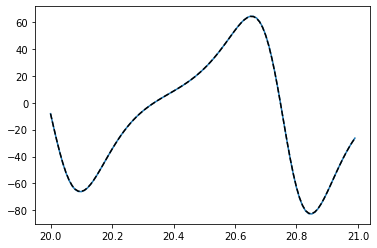

In [7]:
# comparing 
frm_range,to_range=2000,2100
plt.plot(time_steps_lorenz[frm_range:to_range], DerivLorenzArr[0][frm_range:to_range])
plt.plot(time_steps_lorenz[frm_range:to_range], [x[0] for x in X_dot_lorenz[frm_range:to_range]], 'k--')

### Spectral derivatives.
    Assumes uniform grid, and utilizes FFT(Fast Fourier Transform) to approximate a derivative.
    Works well for derivatives in periodic dimensions.
    Equivalent to a maximal-order finite difference, but runs in O(NlogN).

In [11]:
from pysindy.differentiation import SpectralDerivative
sd = SpectralDerivative()
sd_X_dot = sd._differentiate(X_train_odeint, t_train)
sd_X_dot_lorenz = sd._differentiate(X_t_lorenz, time_steps_lorenz)

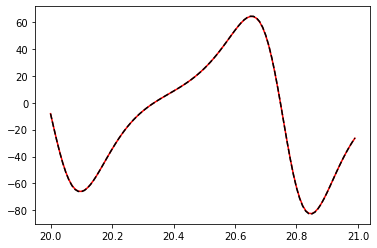

In [15]:
# comparison with finite difference
frm_range,to_range=2000,2100
plt.plot(time_steps_lorenz[frm_range:to_range], [x[0] for x in X_dot_lorenz[frm_range:to_range]], 'r')
plt.plot(time_steps_lorenz[frm_range:to_range], [x[0] for x in sd_X_dot_lorenz[frm_range:to_range]], 'k--')

### Smoothed finite difference derivatives.
    Denoises the data using savgol-filter from scipy which calculates a polynomial fit of order o in each filter-window of width w. 
    After smothing, it applies finite difference method 

In [10]:
from pysindy.differentiation import SmoothedFiniteDifference
t = np.linspace(0,1,10)
X = np.vstack((np.sin(t),np.cos(t))).T
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
xx0=sfd._differentiate(X, t)

array([[ 1.00415134e+00, -1.03791172e-04],
       [ 9.91779070e-01, -1.10702304e-01],
       [ 9.73376491e-01, -2.20038119e-01],
       [ 9.43001496e-01, -3.26517615e-01],
       [ 9.00981354e-01, -4.29066632e-01],
       [ 8.47849424e-01, -5.26323977e-01],
       [ 7.84260982e-01, -6.17090177e-01],
       [ 7.11073255e-01, -7.00180971e-01],
       [ 6.29013295e-01, -7.74740601e-01],
       [ 5.42632624e-01, -8.44908142e-01]])

In [ ]:
t = np.linspace(0,1,10)
X = np.vstack((np.sin(t),np.cos(t))).T
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
xx0=fd._differentiate(X, t)